# Presentation Figures

Generating simplified visuals for presentation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
decades = ['60s', '70s', '80s', '90s', '00s', '10s']
dfs = []
for decade in decades:
    df = pd.read_csv(f'../data/dataset-of-{decade}.csv')
    df['decade'] = decade
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df.shape

(41106, 20)

In [3]:
dataset_recent = df[df['decade'].isin(['00s', '10s'])].copy()

import pickle
with open('../data/artist_cache.pkl', 'rb') as f:
    artist_cache = pickle.load(f)

for idx, row in dataset_recent.iterrows():
    uri = row['uri']
    if uri in artist_cache:
        dataset_recent.loc[idx, 'artist_popularity'] = artist_cache[uri]['artist_popularity']
        dataset_recent.loc[idx, 'artist_followers'] = artist_cache[uri]['artist_followers']

dataset_recent.shape

(12270, 22)

In [4]:
audio_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
                  'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 
                  'duration_ms', 'time_signature', 'chorus_hit', 'sections']

augmented_features = audio_features + ['artist_popularity', 'artist_followers']

X_aug = dataset_recent[augmented_features]
y_aug = dataset_recent['target']

X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(
    X_aug, y_aug, test_size=0.2, stratify=y_aug, random_state=42
)

X_train_aug.shape, X_test_aug.shape

((9816, 17), (2454, 17))

In [5]:
rf_augmented = RandomForestClassifier(n_estimators=200, max_depth=25, random_state=42)
rf_augmented.fit(X_train_aug, y_train_aug)

feature_importance_aug = pd.DataFrame({
    'feature': augmented_features,
    'importance': rf_augmented.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance_aug.head(10)

,feature,importance
16,artist_followers,0.290752
15,artist_popularity,0.182964
7,instrumentalness,0.126198
0,danceability,0.060954
3,loudness,0.057061
6,acousticness,0.049387
1,energy,0.041787
11,duration_ms,0.040168
9,valence,0.033692
5,speechiness,0.025670


## Figure 1: Artist vs Audio Feature Importance

The 47% claim

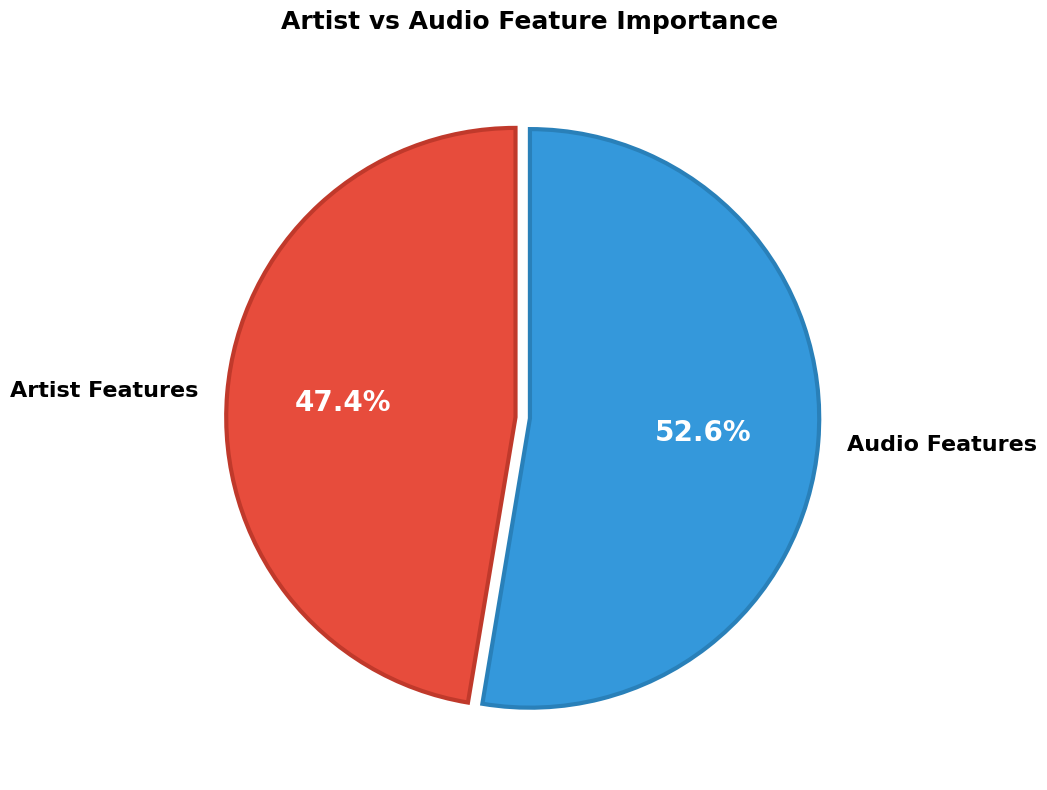

Artist features: 47.4%
Audio features: 52.6%


In [14]:
artist_importance = feature_importance_aug[feature_importance_aug['feature'].isin(['artist_followers', 'artist_popularity'])]['importance'].sum()
audio_importance = feature_importance_aug[~feature_importance_aug['feature'].isin(['artist_followers', 'artist_popularity'])]['importance'].sum()

importance_data = pd.DataFrame({
    'Category': ['Artist Features', 'Audio Features'],
    'Importance': [artist_importance, audio_importance]
})

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#e74c3c', '#3498db']
edge_colors = ['#c0392b', '#2980b9']
explode = (0.05, 0)

wedges, texts, autotexts = ax.pie(
    importance_data['Importance'], 
    labels=importance_data['Category'],
    autopct='%1.1f%%',
    colors=colors,
    explode=explode,
    startangle=90,
    textprops={'fontsize': 16, 'fontweight': 'bold'}
)

for i, wedge in enumerate(wedges):
    wedge.set_edgecolor(edge_colors[i])
    wedge.set_linewidth(3)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(20)

ax.set_title('Artist vs Audio Feature Importance', fontsize=18, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('figures/artist_vs_audio_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Artist features: {artist_importance:.1%}")
print(f"Audio features: {audio_importance:.1%}")

## Figure 2: Model Performance Ceiling

The 91% accuracy result

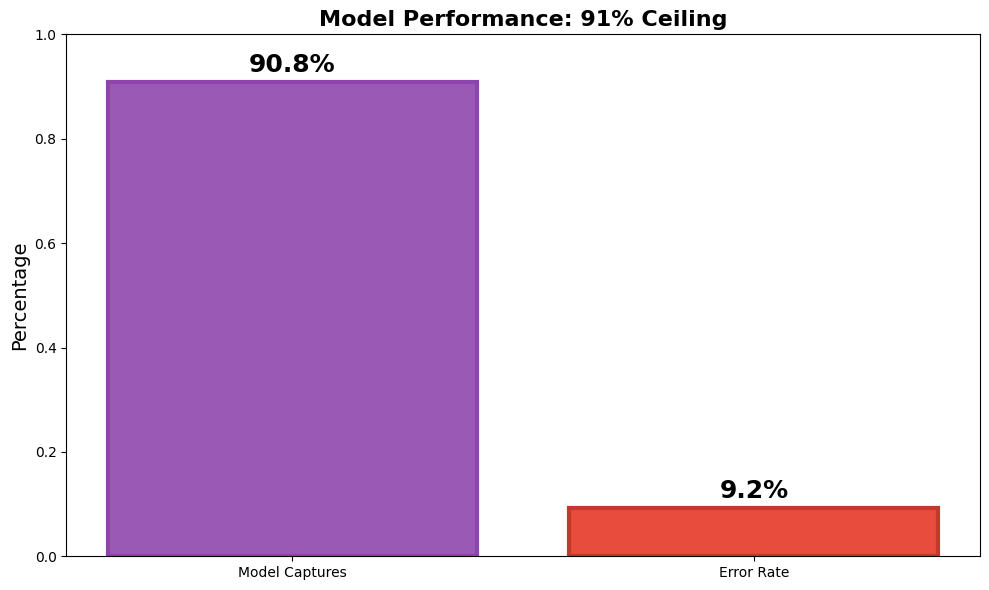

Model accuracy: 90.8%
Error rate: 9.2%


In [15]:
ceiling_data = pd.DataFrame({
    'Category': ['Model Captures', 'Error Rate'],
    'Percentage': [0.908, 0.092]
})

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#9b59b6', '#e74c3c']
edge_colors = ['#8e44ad', '#c0392b']
bars = ax.bar(ceiling_data['Category'], ceiling_data['Percentage'], color=colors, 
              edgecolor=edge_colors, linewidth=3)

ax.set_ylabel('Percentage', fontsize=14)
ax.set_ylim(0, 1.0)
ax.set_title('Model Performance: 91% Ceiling', fontsize=16, fontweight='bold')

for i, v in enumerate(ceiling_data['Percentage']):
    ax.text(i, v + 0.02, f'{v:.1%}', ha='center', fontsize=18, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/performance_ceiling.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Model accuracy: {ceiling_data['Percentage'][0]:.1%}")
print(f"Error rate: {ceiling_data['Percentage'][1]:.1%}")

## Figure 3: Feature Importance Shift

Audio-only vs augmented model comparison

In [9]:
X_audio = dataset_recent[audio_features]
y_audio = dataset_recent['target']

X_train_audio, X_test_audio, y_train_audio, y_test_audio = train_test_split(
    X_audio, y_audio, test_size=0.2, stratify=y_audio, random_state=42
)

rf_audio = RandomForestClassifier(n_estimators=200, max_depth=25, random_state=42)
rf_audio.fit(X_train_audio, y_train_audio)

feature_importance_audio = pd.DataFrame({
    'feature': audio_features,
    'importance': rf_audio.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance_audio.head(5)

,feature,importance
7,instrumentalness,0.237176
0,danceability,0.112206
3,loudness,0.104339
6,acousticness,0.091985
1,energy,0.084371


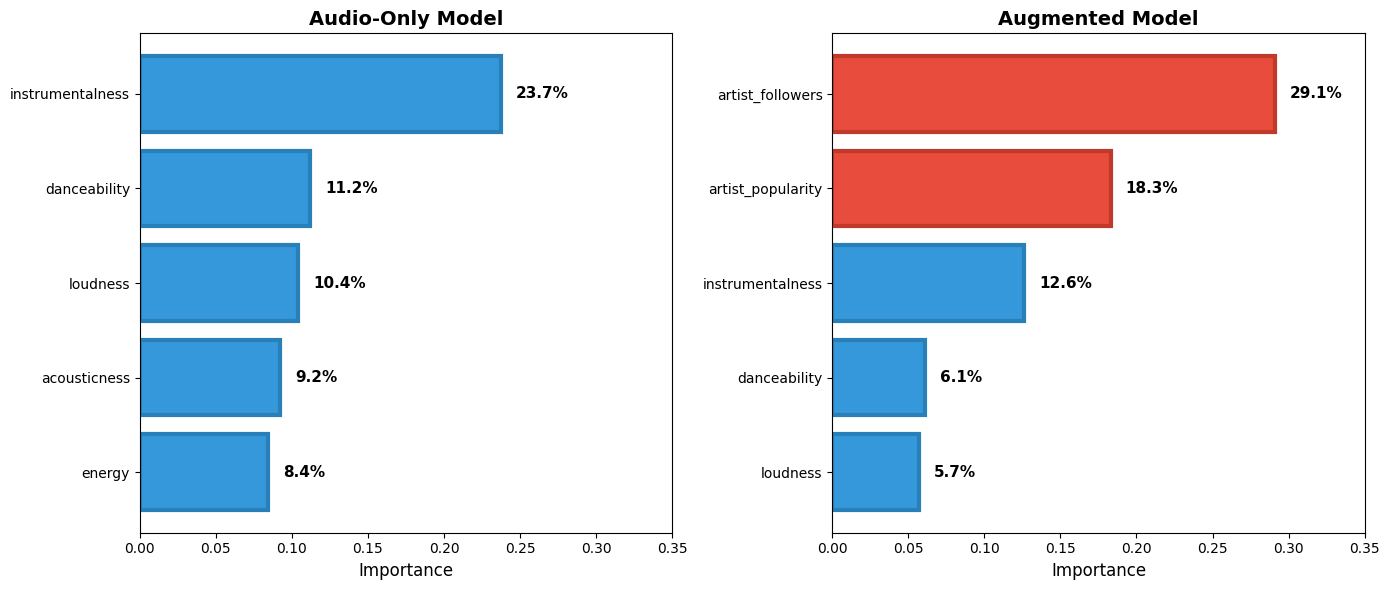

Audio-only top feature: instrumentalness (23.7%)
Augmented top feature: artist_followers (29.1%)


In [16]:
top_audio = feature_importance_audio.head(5)
top_augmented = feature_importance_aug.head(5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.barh(top_audio['feature'], top_audio['importance'], color='#3498db', 
         edgecolor='#2980b9', linewidth=3)
ax1.set_xlabel('Importance', fontsize=12)
ax1.set_title('Audio-Only Model', fontsize=14, fontweight='bold')
ax1.set_xlim(0, 0.35)
ax1.invert_yaxis()
for i, v in enumerate(top_audio['importance']):
    ax1.text(v + 0.01, i, f'{v:.1%}', va='center', fontsize=11, fontweight='bold')

colors_augmented = ['#e74c3c' if f in ['artist_followers', 'artist_popularity'] else '#3498db' 
                    for f in top_augmented['feature']]
edge_colors_augmented = ['#c0392b' if f in ['artist_followers', 'artist_popularity'] else '#2980b9' 
                         for f in top_augmented['feature']]

ax2.barh(top_augmented['feature'], top_augmented['importance'], color=colors_augmented,
         edgecolor=edge_colors_augmented, linewidth=3)
ax2.set_xlabel('Importance', fontsize=12)
ax2.set_title('Augmented Model', fontsize=14, fontweight='bold')
ax2.set_xlim(0, 0.35)
ax2.invert_yaxis()
for i, v in enumerate(top_augmented['importance']):
    ax2.text(v + 0.01, i, f'{v:.1%}', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/feature_importance_shift.png', dpi=300, bbox_inches='tight')
plt.show()

print("Audio-only top feature:", top_audio.iloc[0]['feature'], f"({top_audio.iloc[0]['importance']:.1%})")
print("Augmented top feature:", top_augmented.iloc[0]['feature'], f"({top_augmented.iloc[0]['importance']:.1%})")

## Figure 4: Model Accuracy Progression

Simplified model accuracy progression bar chart

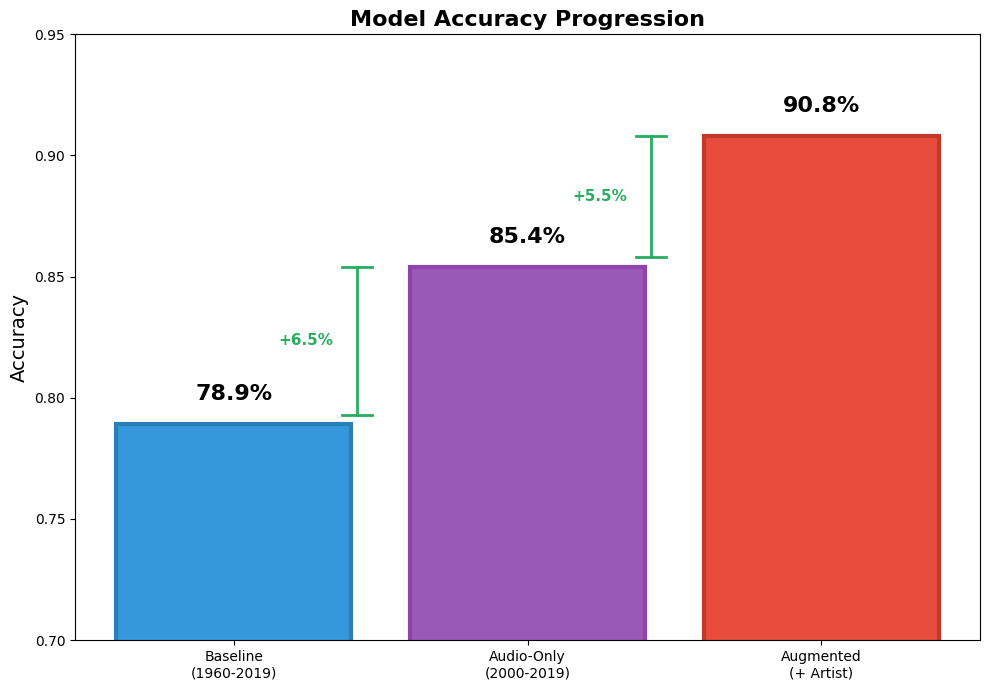

In [20]:
fig, ax = plt.subplots(figsize=(10, 7))

models = ['Baseline\n(1960-2019)', 'Audio-Only\n(2000-2019)', 'Augmented\n(+ Artist)']
accuracies = [0.789, 0.854, 0.908]
colors = ['#3498db', '#9b59b6', '#e74c3c']
edge_colors = ['#2980b9', '#8e44ad', '#c0392b']

bars = ax.bar(models, accuracies, color=colors, edgecolor=edge_colors, linewidth=3)

ax.set_ylabel('Accuracy', fontsize=14)
ax.set_ylim(0.7, 0.95)
ax.set_title('Model Accuracy Progression', fontsize=16, fontweight='bold')

for i, v in enumerate(accuracies):
    ax.text(i, v + 0.01, f'{v:.1%}', ha='center', fontsize=16, fontweight='bold')

bracket_color = '#27ae60'
bracket_x_offset = 0.42

ax.plot([0 + bracket_x_offset, 0 + bracket_x_offset], [0.793, 0.854], 
        color=bracket_color, lw=2)
ax.plot([0 + bracket_x_offset - 0.05, 0 + bracket_x_offset + 0.05], [0.793, 0.793], 
        color=bracket_color, lw=2)
ax.plot([0 + bracket_x_offset - 0.05, 0 + bracket_x_offset + 0.05], [0.854, 0.854], 
        color=bracket_color, lw=2)
ax.text(0 + bracket_x_offset - 0.08, (0.793 + 0.854) / 2, '+6.5%', 
        va='center', ha='right', fontsize=11, fontweight='bold', color=bracket_color)

ax.plot([1 + bracket_x_offset, 1 + bracket_x_offset], [0.858, 0.908], 
        color=bracket_color, lw=2)
ax.plot([1 + bracket_x_offset - 0.05, 1 + bracket_x_offset + 0.05], [0.858, 0.858], 
        color=bracket_color, lw=2)
ax.plot([1 + bracket_x_offset - 0.05, 1 + bracket_x_offset + 0.05], [0.908, 0.908], 
        color=bracket_color, lw=2)
ax.text(1 + bracket_x_offset - 0.08, (0.858 + 0.908) / 2, '+5.5%', 
        va='center', ha='right', fontsize=11, fontweight='bold', color=bracket_color)

plt.tight_layout()
plt.savefig('figures/accuracy_progression_simple.png', dpi=300, bbox_inches='tight')
plt.show()

## Figure 5: Confusion Matrix Comparison

Random split vs temporal split validation

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score

temporal_train = dataset_recent[dataset_recent['decade'] == '00s'].copy()
temporal_test = dataset_recent[dataset_recent['decade'] == '10s'].copy()

for idx, row in temporal_train.iterrows():
    uri = row['uri']
    if uri in artist_cache:
        temporal_train.loc[idx, 'artist_popularity'] = artist_cache[uri]['artist_popularity']
        temporal_train.loc[idx, 'artist_followers'] = artist_cache[uri]['artist_followers']

for idx, row in temporal_test.iterrows():
    uri = row['uri']
    if uri in artist_cache:
        temporal_test.loc[idx, 'artist_popularity'] = artist_cache[uri]['artist_popularity']
        temporal_test.loc[idx, 'artist_followers'] = artist_cache[uri]['artist_followers']

X_train_temp = temporal_train[augmented_features]
y_train_temp = temporal_train['target']
X_test_temp = temporal_test[augmented_features]
y_test_temp = temporal_test['target']

rf_temporal = RandomForestClassifier(n_estimators=200, max_depth=25, random_state=42)
rf_temporal.fit(X_train_temp, y_train_temp)
y_pred_temp = rf_temporal.predict(X_test_temp)

y_pred_random = rf_augmented.predict(X_test_aug)

cm_random = confusion_matrix(y_test_aug, y_pred_random)
cm_temporal = confusion_matrix(y_test_temp, y_pred_temp)

print(f"Random split accuracy: {accuracy_score(y_test_aug, y_pred_random):.1%}")
print(f"Temporal split accuracy: {accuracy_score(y_test_temp, y_pred_temp):.1%}")

Random split accuracy: 90.8%
Temporal split accuracy: 89.3%


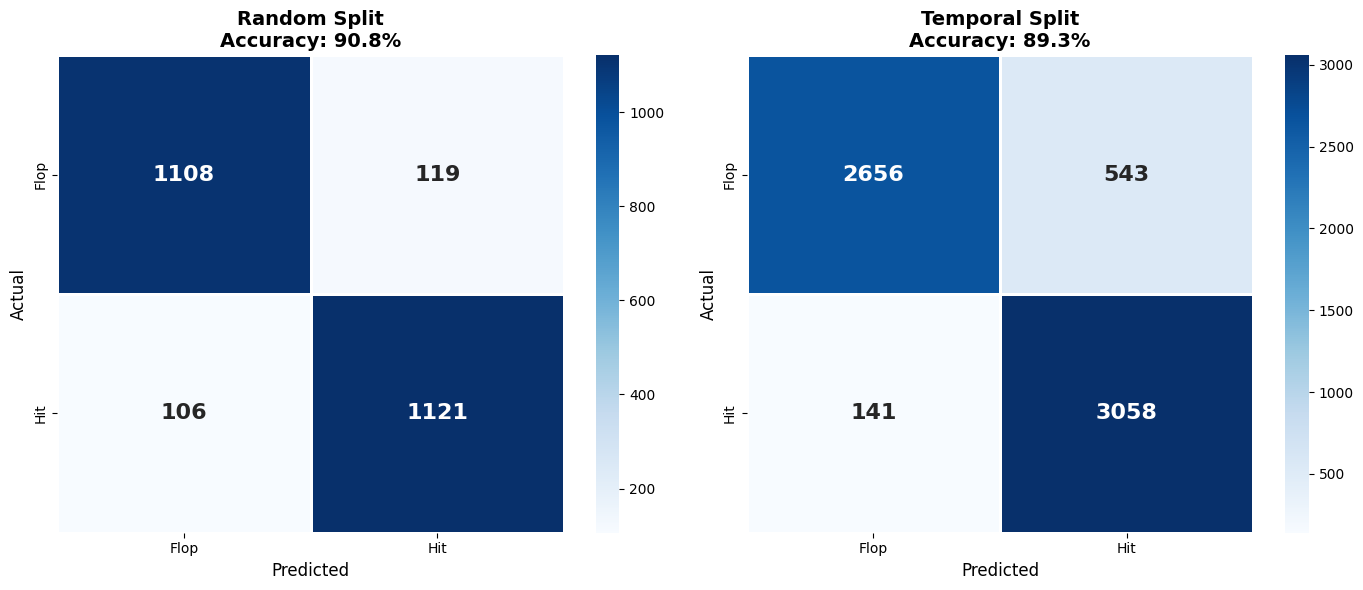

Random split - FP: 119, FN: 106
Temporal split - FP: 543, FN: 141


In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_random, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Flop', 'Hit'], yticklabels=['Flop', 'Hit'],
            annot_kws={'size': 16, 'weight': 'bold'},
            linewidths=2, linecolor='white')
ax1.set_xlabel('Predicted', fontsize=12)
ax1.set_ylabel('Actual', fontsize=12)
ax1.set_title(f'Random Split\nAccuracy: 90.8%', fontsize=14, fontweight='bold')

sns.heatmap(cm_temporal, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Flop', 'Hit'], yticklabels=['Flop', 'Hit'],
            annot_kws={'size': 16, 'weight': 'bold'},
            linewidths=2, linecolor='white')
ax2.set_xlabel('Predicted', fontsize=12)
ax2.set_ylabel('Actual', fontsize=12)
ax2.set_title(f'Temporal Split\nAccuracy: 89.3%', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/confusion_matrix_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Random split - FP: {cm_random[0,1]}, FN: {cm_random[1,0]}")
print(f"Temporal split - FP: {cm_temporal[0,1]}, FN: {cm_temporal[1,0]}")